# Predicting Bank Marketing Campaign Outcomes Using Machine Learning

https://www.kaggle.com/code/hariharanpavan/bank-marketing-analysis

| Header     | Data Type | Definition |
|------------|----------|------------|
| Age        | int64    | Age of customer |
| Job        | object   | Job of customer |
| Marital    | object   | Marital status of customer |
| Education  | object   | Customer education level |
| Default    | object   | Has credit in default? |
| Housing    | object   | If customer has housing loan |
| Loan       | object   | Has Personal Loan |
| Balance    | int64    | Customer's individual balance |
| Contact    | object   | Communication type |
| Month      | object   | Last contact month of year |
| Day        | int64    | Last contact day of the week |
| Duration   | int64    | Last contact duration, in seconds |
| Campaign   | int64    | Number of contacts performed during this campaign and for this client |
| Pdays      | int64    | Number of days that passed by after the client was last contacted from a previous campaign |
| Previous   | int64    | Number of contacts performed before this campaign and for this client |
| Poutcome   | object   | Outcome of the previous marketing campaign |
| Y          | object   | Has the client subscribed to a term deposit? |


## 1. Importing Libraries

In [46]:
# ------------------------------------
# Essential Libraries
# ------------------------------------
import pandas as pd                     # For data loading and manipulation
import numpy as np                      # For numerical operations
import warnings                         # To suppress warnings in output
warnings.filterwarnings("ignore")

# ------------------------------------
# Data Visualization
# ------------------------------------
import matplotlib.pyplot as plt         # For plotting feature importance or distributions

# ------------------------------------
# Data Preprocessing
# ------------------------------------
from sklearn.model_selection import train_test_split                        # For splitting train/test sets
from sklearn.model_selection import StratifiedKFold, cross_val_score        # # For performing stratified k-fold cross-validation to check model stability across folds
from sklearn.preprocessing import LabelEncoder                              # For encoding categorical features
from sklearn.impute import SimpleImputer                                    # For handling missing values
from sklearn.utils import class_weight                                      # Needed to compute balanced class weights

# ------------------------------------
# Machine Learning Model
# ------------------------------------
import xgboost as xgb       # Main model for classification

# ------------------------------------
# Evaluation Metrics
# ------------------------------------
from sklearn.metrics import (
    classification_report,          # Precision, recall, F1, etc.
    roc_auc_score                   # ROC-AUC metric
)


## 2. Load Data

In [52]:
# The training set contains features and target labels.
# The query set contains only features; we will predict the target for these later.

train = pd.read_csv("trainingset.txt", sep=",")         # Load training data
queries = pd.read_csv("queries.txt", sep=",")           # Load query data

train.columns = train.columns.str.strip()               # Remove whitespace from training set columns
queries.columns = queries.columns.str.strip()           # Remove whitespace from query set columns

# Look at the data to understand structure and missing values
print(train.head())
print("------------------------------------------------")
print(train.info())
print("------------------------------------------------")
print(train.isnull().sum())

   age      job   marital  education default  balance housing loan  contact  \
0   44  JobCat9    single  secondary      no       29     yes   no  unknown   
1   47  JobCat3   married    unknown      no     1506     yes   no  unknown   
2   31  unknown    single    unknown      no        1      no   no  unknown   
3   26  JobCat6    single   tertiary      no      447     yes  yes  unknown   
4   42  JobCat4  divorced   tertiary     yes        2     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome      y  
0    5   may         0         1     -1         0  unknown  TypeA  
1    5   may         0         1     -1         0  unknown  TypeA  
2    5   may         0         1     -1         0  unknown  TypeA  
3    5   may         0         1     -1         0  unknown  TypeA  
4    5   may         0         1     -1         0  unknown  TypeA  
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27272 entries, 0 t

## 3. Preprocessing

### a. Missing values

In [53]:
# Train data, numeric columns: fill missing values with median (robust to outliers)
for col in train.select_dtypes(include='number'):
    train[col].fillna(train[col].median(), inplace=True)

# Train data, categorical columns: fill missing values with a placeholder ("Unknown")
for col in train.select_dtypes(exclude='number'):
    train[col].fillna("Unknown", inplace=True)

# Query data, numeric columns: fill missing values with median (robust to outliers)
for col in queries.select_dtypes(include='number'):
    queries[col].fillna(train[col].median(), inplace=True)  # Use train median

# Query data, categorical columns: fill missing values with a placeholder ("Unknown")
for col in queries.select_dtypes(exclude='number'):
    queries[col].fillna("Unknown", inplace=True)

# Replace explicit '?' values to avoid unseen-category errors
train.replace("?", "Unknown", inplace=True)
queries.replace("?", "Unknown", inplace=True)

### b. Encode categorical features

In [54]:
# Label encoding converts categories into integers while preserving uniqueness. This avoids unnecessary one-hot encoding and keeps the pipeline simple.

categorical_cols = [col for col in train.select_dtypes(exclude='number').columns if col != 'y']     # Select all categorical feature columns in the training set for encoding, excluding the target 'y'


for col in categorical_cols:
    le = LabelEncoder()

    # Fit the encoder on the combined unique values from both train and query datasets
    # This ensures that all categories, including any placeholders like "unknown", are recognized
    le.fit(pd.concat([train[col], queries[col]]))               # Combine unique categories from train and queries

    # Transform training data using the fitted encoder
    # Converts string categories into integer labels, preserving uniqueness
    train[col] = le.fit_transform(train[col])

    # Transform query data using the same mapping learned from train+query fit
    # Prevents errors caused by previously unseen labels in the query set
    queries[col] = le.transform(queries[col])

# Convert target 'y' to numeric (0/1)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(train['y'])      # e.g., TypeA -> 0, TypeB -> 1
train['y'] = y_encoded                          # replace original target column

### c. Feature / Target separation

In [55]:
# Separate the features (X) from the target variable (y)

X = train.drop(columns=['y'])       # y is the target feature
y = y_encoded

## 3. Split Data

In [ ]:
# Use a stratified split to preserve the original class distribution.
# Test set is used for final evaluation to ensure generalization.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,                         # ensures both train and test sets maintain the same proportion of each class, which is critical for imbalanced datasets.
    random_state=42
)

# Convert y_train and y_test from NumPy arrays back to pandas Series for convenience (e.g., value_counts)
y_train = pd.Series(y_train, name='y_train')
y_test = pd.Series(y_test, name='y_test')

# Print summary
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in train:", y_train.value_counts())
print("Class distribution in test:", y_test.value_counts())

Training set shape: (21817, 16)
Test set shape: (5455, 16)
Class distribution in train: 0    19223
1     2594
Name: y_train, dtype: int64
Class distribution in test: 0    4807
1     648
Name: y_test, dtype: int64


## 4. Model Selection: XGBoost

In [58]:
# hhttps://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
# XGBoost is chosen because it handles imbalanced datasets well and allows weighting of classes.

# Calculate class weight
# 'balanced' computes weights inversely proportional to class frequencies to ensure that the minority class has more influence during training
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), weights))                                                # Map each class to its weight

# scale_pos_weight is set to give more importance to the minority class; 
# it helps improve recall and F1 for the underrepresented class without generating synthetic samples (avoids overfitting pitfalls of SMOTE/SMOTE-ENN)

# Use standard hyperparameters for tabular data
model = xgb.XGBClassifier(
    n_estimators=200,                   # number of boosting rounds; higher can improve accuracy but risk overfitting
    max_depth=5,                        # maximum depth of each tree; controls model complexity
    learning_rate=0.1,                  # step size shrinkage for each boosting round; smaller values make training more robust
    subsample=0.8,                      # fraction of rows used per tree; helps reduce overfitting
    colsample_bytree=0.8,               # fraction of features used per tree; helps reduce overfitting
    scale_pos_weight=weights[1],        # weight for minority class to address imbalance
    eval_metric='logloss',              # loss function for binary classification
    use_label_encoder=False,            # avoid deprecated label encoder warning
    random_state=42                     # ensures consistent, reproducible result
)

# Confirm model stability with stratified 5-fold CV

# StratifiedKFold ensures that class distribution is preserved in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')      # ROC-AUC is used as the evaluation metric for imbalanced data

print("5-fold CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

# Fit XGBoost on the full training set for final evaluation and query predictions
model.fit(X_train, y_train)

5-fold CV ROC-AUC scores: [0.7991907  0.80205482 0.77973149 0.78853063 0.79848785]
Mean CV ROC-AUC: 0.7935990970089644


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5. Evaluation

In [ ]:
y_pred = model.predict(X_test)                      # Predict class labels (0/1) for X_test
y_prob = model.predict_proba(X_test)[:,1]           # Predict probabilities for the positive class (useful for ROC-AUC and threshold tuning)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4807
           1       0.43      0.49      0.46       648

    accuracy                           0.86      5455
   macro avg       0.68      0.70      0.69      5455
weighted avg       0.87      0.86      0.87      5455

ROC-AUC: 0.7905597418373926


## 6. Predictions for Query Dataset

In [60]:
# Prepare query data for prediction
X_query = queries.drop(columns=['y'], errors='ignore')      # Drop target column if present

# Make predictions
query_predictions = model.predict(X_query)

# Map numeric predictions back to original labels if needed
query_predictions_labels = le_y.inverse_transform(query_predictions)

# Save predictions in the format <query_number>,<prediction>
output = pd.DataFrame({
    'query': X_query.index + 1,         # query numbers start from 1
    'prediction': query_predictions
})
output.to_csv("predictions.txt", index=False, header=False)


## 7. Feature Importance

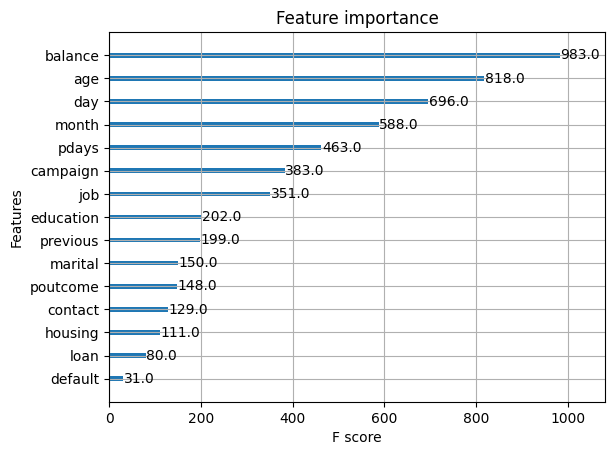

In [61]:
# Plot featrure importance
xgb.plot_importance(model)
plt.show()

In [62]:
# Extract and save feature importance
importance_array = model.feature_importances_       # sklearn-style attribute, gives normalized importance

importance_df = pd.DataFrame({
    'feature': X_train.columns,             # make sure X_train has column names
    'importance': importance_array
}).sort_values(by='importance', ascending=False)

# Save feature importance for reporting / reproducibility
importance_df.to_csv("feature_importance.csv", index=False)


## 8. Conclusion

The **XGBoost model** demonstrates strong overall performance on this imbalanced dataset, achieving an **accuracy of 0.86 and ROC-AUC of 0.79**. 

**Stratified 5-fold cross-validation** confirms the model is stable, with consistent ROC-AUC scores across folds.

Metrics for the minority class are lower (recall 0.49, F1 0.46), reflecting the challenge of predicting the less frequent outcome. **This means the model is better at identifying the majority class than the minority class**.

**Feature importance** analysis shows which predictors contribute most to model decisions, providing insights for future feature engineering or data collection. 

Using **class weighting** effectively mitigates imbalance without creating overfitting on the majority class. 

Overall, the model provides a reasonable balance between predictive performance and interpretability for this structured marketing dataset. 

**K-fold cross-validation** ensures that the evaluation is not dependent on a single split, increasing confidence that the model will generalize well to new data.

**Hyperparameter tuning** was not performed because the standard XGBoost parameters already achieved strong and stable performance on this dataset, and further tuning would provide minimal improvement while adding unnecessary complexity and computational cost.